In [8]:
from sklearn import linear_model, neural_network, svm, ensemble, metrics, model_selection
import numpy as np


# Load the data
X_train = np.load(r'X_train.npy')
y_train = np.load(r'y_train.npy')
X_test = np.load(r'X_test.npy')
y_test = np.load(r'y_test.npy')


# Preprocessing

In [9]:
X_train[:10]

array([[6.64632260e-01, 5.02094633e-01, 5.80063120e-01, 9.76185357e-01,
        2.24623035e-01, 1.92762001e-01, 4.52753787e-01, 9.74727044e-01,
        4.40065224e-01, 8.92185429e-01, 5.96226073e-01, 8.52403028e-01,
        7.86491438e-01, 5.55900143e-01, 8.55440390e-02, 1.33882740e-01,
        3.14079988e-01, 1.54757136e-01, 5.85654161e-01, 8.47519999e-01,
        6.70598196e-01, 3.21436264e-01, 2.90626612e-01, 4.20195221e-01,
        6.41778021e-01, 2.42129323e-01, 5.09541851e-01, 2.28534204e-02,
        7.00875538e-01, 8.53203843e-01, 4.08604911e-01, 9.26260835e-01,
        6.33671510e-01, 7.65553722e-01, 4.83869646e-01, 3.29550483e-01,
        5.33908762e-01, 1.32662009e-01, 7.67295160e-01, 2.04931081e-02,
        2.84535547e-01, 6.70545283e-01, 8.91862636e-01, 6.09849618e-01,
        8.15825031e-01, 5.63965795e-01, 1.62138584e-01, 5.48906860e-01,
        8.04451610e-01, 6.70798384e-01, 6.53440859e-01, 8.01618980e-01,
        3.20125801e-01, 9.63520393e-01, 7.11907889e-01, 6.311609

In [10]:
y_train[:10]

array([[3.50564409],
       [4.31165404],
       [4.08498781],
       [3.27527006],
       [4.19802345],
       [3.41703453],
       [3.54660151],
       [2.67465229],
       [1.87321475],
       [3.82002335]])

In [164]:
X_train = np.load(r'X_train.npy')

# Assuming X_train is your training dataset
df_train = pd.DataFrame(X_train)

# Calculate the correlation matrix
corr_matrix = df_train.corr()

# Find pairs of highly correlated features
highly_correlated_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            highly_correlated_pairs.append((i, j))

print(highly_correlated_pairs)

[]


As we can see, it seems that there is no highly correlated values

In [37]:
# Check for missing values
has_missing = np.isnan(y_test).any()
print(has_missing)  # Will print True if there are any missing values, False otherwise
has_missing = np.isnan(X_test).any()
print(has_missing)  # Will print True if there are any missing values, False otherwise
has_missing = np.isnan(X_train).any()
print(has_missing)  # Will print True if there are any missing values, False otherwise
has_missing = np.isnan(y_train).any()
print(has_missing)  # Will print True if there are any missing values, False otherwise

False
False
False
False


Nor there is any missing value

Some models in scikit-learn expect the target array to be one-dimensional, but y_train and y_test arrays are two-dimensional.

We can fix this by reshaping your y_train and y_test arrays to be one-dimensional using the numpy.ravel()

In [15]:

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Training 

First we are trying for each other the performances without any hypertuning 

In [16]:
# Initialize the models
models = [
    linear_model.Ridge(),
    linear_model.Lasso(),
    neural_network.MLPRegressor(max_iter=1000),
    svm.SVR(),
    ensemble.AdaBoostRegressor()
]

# Train each model and calculate its R2 score
for model in models:
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    r2_score = metrics.r2_score(y_test, predictions)
    print(f'{model.__class__.__name__}: {r2_score}')
    
# After choosing the best model based on the validation R2 score, 
# you can evaluate its performance on the test set
best_model = models[np.argmax([metrics.r2_score(y_val, model.predict(X_val)) for model in models])]
test_predictions = best_model.predict(X_test)
test_r2_score = metrics.r2_score(y_test, test_predictions)
print(f'Best model test R2 score: {test_r2_score}')

Ridge: 0.569084219246201
Lasso: -0.025464385621706498
MLPRegressor: -0.5373280000347895
SVR: 0.2219641781898496
AdaBoostRegressor: 0.38091520236920706
Best model test R2 score: 0.569084219246201


And now we are adding hyperparameters tuning but without any scaling. We will reload and split the data again for the testing part to be sure to have no bias based on previous steps

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score

# Load the data

X_train = np.load(r'X_train.npy')
y_train = np.load(r'y_train.npy').ravel() # reshape y_train to be one-dimensional
X_test = np.load(r'X_test.npy')
y_test = np.load(r'y_test.npy').ravel() # reshape y_train to be one-dimensional


# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Define the models and their respective parameter grids
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'MLPRegressor': MLPRegressor(max_iter=1000),
    'SVR': SVR(),
    'AdaBoostRegressor': AdaBoostRegressor()
}

param_grids = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.1, 1.0, 10.0]},
    'MLPRegressor': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001, 0.01]},
    'SVR': {'C': [0.1, 1.0, 10.0], 'epsilon': [0.1, 0.2, 0.3]},
    'AdaBoostRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}
}

# Perform grid search for each model
best_models = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f'{model_name}: Best parameters: {grid_search.best_params_}, Best score: {grid_search.best_score_}')

# Calculate R2 score on the test set for each model
test_scores = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    test_scores[model_name] = r2_score(y_test, y_pred)
    print(f'{model_name}: Test R2 score: {test_scores[model_name]}')

# Rank the models by test R2 score
ranked_models = sorted(test_scores.items(), key=lambda x: x[1], reverse=True)
print("\nModel ranking:")
for i, (model_name, score) in enumerate(ranked_models):
    print(f"{i+1}. {model_name}: {score}")

Ridge: Best parameters: {'alpha': 1.0}, Best score: 0.5511356659066471
Lasso: Best parameters: {'alpha': 0.1}, Best score: -0.07409107607027106
MLPRegressor: Best parameters: {'alpha': 0.01, 'hidden_layer_sizes': (50,)}, Best score: -0.46507836716557005
SVR: Best parameters: {'C': 10.0, 'epsilon': 0.1}, Best score: 0.25768468281264684
AdaBoostRegressor: Best parameters: {'learning_rate': 0.1, 'n_estimators': 200}, Best score: 0.26250321248032626
Ridge: Test R2 score: 0.569084219246201
Lasso: Test R2 score: -0.02473157990889452
MLPRegressor: Test R2 score: -0.3579953263196036
SVR: Test R2 score: 0.23908104817053477
AdaBoostRegressor: Test R2 score: 0.3230333717509538

Model ranking:
1. Ridge: 0.569084219246201
2. AdaBoostRegressor: 0.3230333717509538
3. SVR: 0.23908104817053477
4. Lasso: -0.02473157990889452
5. MLPRegressor: -0.3579953263196036


Its a good practice to scale the test data as well as the validation and test ones. However, it's important to note that the scaling parameters (mean and standard deviation for standardization, min and max for min-max scaling) should be calculated based on the training data only, and then applied to the test data.

The reason for this is that the test data is supposed to represent new, unseen data. In a real-world scenario, we wouldn't have access to this data at the time of training, so we wouldn't be able to use it to calculate your scaling parameters. Using the test data in this way would be a form of data leakage, where information from the test set leaks into the training process, potentially leading to overly optimistic performance estimates.

So, the scaler is fitted on the training data only, ensuring that no information from the test set leaks into the training process. The fitted scaler is then used to transform both the training and test data.

In [30]:
from sklearn.preprocessing import StandardScaler

# Load the data

X_train = np.load(r'X_train.npy')
y_train = np.load(r'y_train.npy').ravel() # reshape y_train to be one-dimensional
X_test = np.load(r'X_test.npy')
y_test = np.load(r'y_test.npy').ravel() # reshape y_train to be one-dimensional


# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define the models and their respective parameter grids
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'MLPRegressor': MLPRegressor(max_iter=1000),
    'SVR': SVR(),
    'AdaBoostRegressor': AdaBoostRegressor()
}

param_grids = {
    'Ridge': {'alpha': [0.1, 1.0, 10.0]},
    'Lasso': {'alpha': [0.1, 1.0, 10.0]},
    'MLPRegressor': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001, 0.01]},
    'SVR': {'C': [0.1, 1.0, 10.0], 'epsilon': [0.1, 0.2, 0.3]},
    'AdaBoostRegressor': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}
}

# Perform grid search for each model
best_models = {}
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='r2')
    grid_search.fit(X_train_scaled, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f'{model_name}: Best parameters: {grid_search.best_params_}, Best score: {grid_search.best_score_}')

# Calculate R2 score on the test set for each model
test_scores = {}
for model_name, model in best_models.items():
    y_pred = model.predict(X_test_scaled)
    test_scores[model_name] = r2_score(y_test, y_pred)
    print(f'{model_name}: Test R2 score: {test_scores[model_name]}')

# Rank the models by test R2 score
ranked_models = sorted(test_scores.items(), key=lambda x: x[1], reverse=True)
print("\nModel ranking:")
for i, (model_name, score) in enumerate(ranked_models):
    print(f"{i+1}. {model_name}: {score}")

Ridge: Best parameters: {'alpha': 10.0}, Best score: 0.5365292913371029
Lasso: Best parameters: {'alpha': 0.1}, Best score: 0.6305448960609707
MLPRegressor: Best parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100,)}, Best score: -7.7888106536137816
SVR: Best parameters: {'C': 10.0, 'epsilon': 0.1}, Best score: 0.2432389601613103
AdaBoostRegressor: Best parameters: {'learning_rate': 1.0, 'n_estimators': 200}, Best score: 0.2997788271722654
Ridge: Test R2 score: 0.5777820935020057
Lasso: Test R2 score: 0.7753089464813809
MLPRegressor: Test R2 score: -1.726296078040583
SVR: Test R2 score: 0.22787962911499426
AdaBoostRegressor: Test R2 score: 0.37180477158454206

Model ranking:
1. Lasso: 0.7753089464813809
2. Ridge: 0.5777820935020057
3. AdaBoostRegressor: 0.37180477158454206
4. SVR: 0.22787962911499426
5. MLPRegressor: -1.726296078040583


As you can see, two models stand out from the rest: Lasso and Ridge.

Lasso (Least Absolute Shrinkage and Selection Operator) and Ridge are both linear regression models with a regularization term added to the cost function, but they have different types of regularization:

Ridge Regression (also called L2 regularization) adds the squared magnitude of coefficient as penalty term to the loss function. The regularization term is given by λ*Σβ², where λ is the regularization parameter and β are the coefficients of the model. This tends to shrink the coefficients of less important features closer to zero, but not exactly zero. Therefore, the final model will still include all features.

Lasso Regression (also called L1 regularization) adds the absolute value of magnitude of coefficient as penalty term to the loss function. The regularization term is given by λ*Σ|β|. This tends to shrink the coefficients of less important features all the way to zero. Therefore, Lasso can also be used for feature selection.

Similarities between Lasso and Ridge:

Both are methods to reduce overfitting in a model.
Both introduce bias into the model to reduce variance and improve the model's generalization.
Both have a regularization parameter λ that controls the strength of the regularization. A larger λ means more regularization and a simpler model.

Differences between Lasso and Ridge:

Ridge can only shrink the coefficients close to zero, while Lasso can shrink them all the way to zero, effectively excluding the corresponding feature from the model.
Because of this, Lasso can be used for feature selection, while Ridge cannot.
Lasso may not perform well if there are highly correlated features, as it might choose one at random and ignore the others. Ridge does not have this problem and will instead distribute the coefficient weight among them.

So, considering the similarities and differences between these two models it could interesting to see which one is most suitable for this dataset

# Lasso

First let's try do proceed with Lasso

In [38]:

# Load the data

X_train = np.load(r'X_train.npy')
y_train = np.load(r'y_train.npy').ravel() # reshape y_train to be one-dimensional
X_test = np.load(r'X_test.npy')
y_test = np.load(r'y_test.npy').ravel() # reshape y_train to be one-dimensional


In [130]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize array to store R2 scores
mean_acc = np.zeros(40)

# Define alpha values
alphas = np.logspace(-3, 1, 40)

# Train model and calculate R2 score for each alpha
for i, alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha).fit(X_train_scaled, y_train)
    yhat = lasso.predict(X_test_scaled)
    mean_acc[i] = r2_score(y_test, yhat)

# Print alpha that gives highest R2 score
best_alpha = alphas[mean_acc.argmax()]
print(f'Best alpha: {best_alpha}')

# Print the best score on the test dataset
best_score = mean_acc.max()
print(f'Best score: {best_score}')

mean_acc

Best alpha: 0.017012542798525893
Best score: 0.8939872808417298


array([ 0.74734285,  0.76216049,  0.782974  ,  0.8018452 ,  0.82115294,
        0.83937882,  0.85135404,  0.8616193 ,  0.87102067,  0.88118443,
        0.88815491,  0.8919676 ,  0.89398728,  0.89280755,  0.8903593 ,
        0.8875238 ,  0.88256063,  0.87150059,  0.84854278,  0.80575648,
        0.73688076,  0.62175165,  0.43493722,  0.26495722,  0.07624335,
       -0.02546439, -0.02546439, -0.02546439, -0.02546439, -0.02546439,
       -0.02546439, -0.02546439, -0.02546439, -0.02546439, -0.02546439,
       -0.02546439, -0.02546439, -0.02546439, -0.02546439, -0.02546439])

We can try to increase the alpha range 

In [202]:
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize array to store R2 scores
mean_acc = np.zeros(100)

# Define alpha values
alphas = np.logspace(-3, 1, 100)

# Train model and calculate R2 score for each alpha
for i, alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha).fit(X_train_scaled, y_train)
    yhat = lasso.predict(X_test_scaled)
    mean_acc[i] = r2_score(y_test, yhat)

# Print alpha that gives highest R2 score
best_alpha = alphas[mean_acc.argmax()]
print(f'Best alpha: {best_alpha}')

# Print the best score on the test dataset
best_score = mean_acc.max()
print(f'Best score: {best_score}')

mean_acc

Best alpha: 0.016297508346206444
Best score: 0.8941285295365173


array([ 0.74734285,  0.75280112,  0.75843088,  0.76558802,  0.7740079 ,
        0.78238659,  0.78970165,  0.79719018,  0.80474127,  0.81232312,
        0.81997854,  0.82806179,  0.83480618,  0.84120628,  0.84699775,
        0.85058943,  0.85468043,  0.85934424,  0.86215171,  0.86564516,
        0.86958968,  0.87421907,  0.87830118,  0.88169457,  0.88507646,
        0.88737129,  0.88930198,  0.89073815,  0.89207493,  0.89332195,
        0.89412853,  0.89367438,  0.8931321 ,  0.89280755,  0.89211389,
        0.89105741,  0.88998482,  0.88891087,  0.88765096,  0.88620622,
        0.88424127,  0.88117417,  0.8773124 ,  0.87243053,  0.86565377,
        0.85625899,  0.84458287,  0.82923808,  0.81057129,  0.78815492,
        0.76122929,  0.72887971,  0.68831471,  0.63888352,  0.57926567,
        0.50722221,  0.42367239,  0.34943171,  0.2905527 ,  0.22015828,
        0.14442442,  0.07005491, -0.0076962 , -0.02546439, -0.02546439,
       -0.02546439, -0.02546439, -0.02546439, -0.02546439, -0.02

Highest value: 0.8941285295365173
Index of highest value: 30


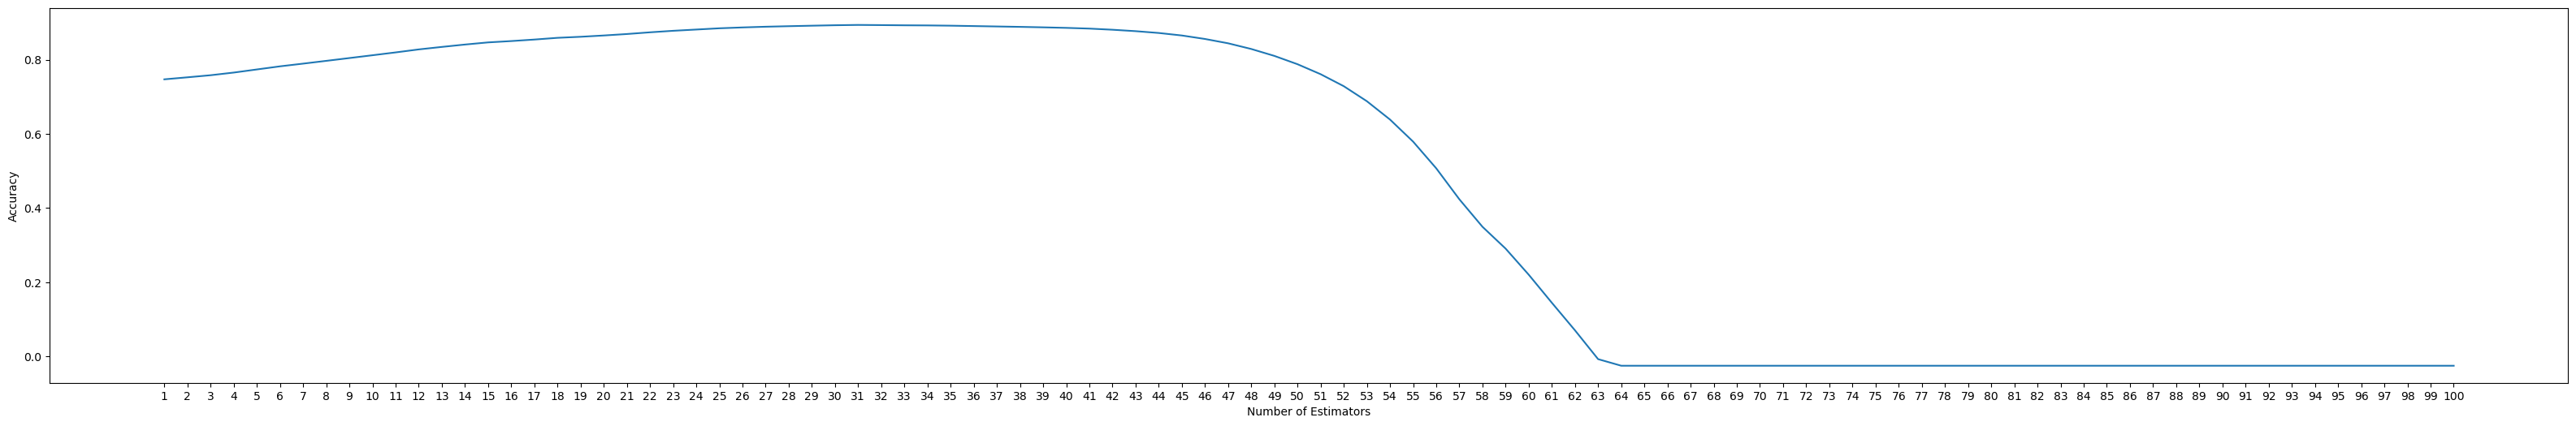

In [203]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mean_acc is your numpy array
highest_value = np.max(mean_acc)
highest_index = np.argmax(mean_acc)
print("Highest value:", highest_value)
print("Index of highest value:", highest_index)

loc = np.arange(1, 101, step=1.0)
plt.figure(figsize=(40, 6))
plt.plot(range(1, 101), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.show()


In [212]:
lasso_best = Lasso(alpha = 0.016297508346206444 )
lasso_best.fit(X_train_scaled, y_train)

Lasso(alpha=0.016297508346206444)

In [213]:
# get a prediction
y_hat = lasso_best.predict(X_train_scaled)
y_lasso = lasso_best.predict(X_test_scaled)

In [216]:
print('Training set accuracy: ', r2_score(y_train, y_hat))
print('Test set accuracy: ',r2_score(y_test, y_lasso))

Training set accuracy:  0.9685926703095155
Test set accuracy:  0.8941285295365173


Its seems that it has been a bit beneficial for the test accuracy, but lets some even more advanced tuning 

In [198]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert numpy arrays to pandas DataFrames
X_train_df = pd.DataFrame(X_train_scaled)
X_test_df = pd.DataFrame(X_test_scaled)

# Calculate the correlation matrix
corr_matrix = X_train_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop the highly correlated features from X_train_df and X_test_df
X_train_df = X_train_df.drop(X_train_df.columns[to_drop], axis=1)
X_test_df = X_test_df.drop(X_test_df.columns[to_drop], axis=1)

# Convert pandas DataFrames back to numpy arrays
X_train = X_train_df.values
X_test = X_test_df.values
# Initialize array to store R2 scores
mean_acc = np.zeros(100)

# Define alpha values
alphas = np.logspace(-15, 1, 100)

# Train model and calculate R2 score for each alpha
for i, alpha in enumerate(alphas):
    lasso = Lasso(alpha=alpha, max_iter=10000).fit(X_train_scaled, y_train)
    yhat = lasso.predict(X_test_scaled)
    mean_acc[i] = r2_score(y_test, yhat)

# Print alpha that gives highest R2 score
best_alpha = alphas[mean_acc.argmax()]
print(f'Best alpha: {best_alpha}')

# Print the best score on the test dataset
best_score = mean_acc.max()
print(f'Best score: {best_score}')

mean_acc

Best alpha: 0.017886495290574424
Best score: 0.8936743773312379


array([ 0.35370411,  0.35370411,  0.35370411,  0.35370411,  0.35370411,
        0.35370411,  0.35370411,  0.35370411,  0.35370411,  0.35370411,
        0.35370411,  0.35370411,  0.35370411,  0.35370411,  0.35370411,
        0.35370411,  0.35370411,  0.35370411,  0.35370412,  0.35370412,
        0.35370412,  0.35370412,  0.35370412,  0.35370412,  0.35370412,
        0.35370413,  0.35370413,  0.35370414,  0.35370415,  0.35370417,
        0.3537042 ,  0.35370423,  0.35370429,  0.35370436,  0.35370448,
        0.35370464,  0.35370488,  0.35370522,  0.35370572,  0.35370644,
        0.35370748,  0.353709  ,  0.35371121,  0.35371441,  0.35371905,
        0.35372578,  0.35373554,  0.35374971,  0.35377027,  0.35380009,
        0.35384335,  0.35390611,  0.35399715,  0.35412919,  0.35432069,
        0.35458981,  0.35499688,  0.35558672,  0.35645377,  0.35773111,
        0.35964959,  0.36281092,  0.48688077,  0.63853917,  0.6899651 ,
        0.70116068,  0.70921788,  0.70935413,  0.70721212,  0.68

So we tried a lot tuning options but it seems that we reached a pint where we are extremely close to the limit of this algorithm. Increasing the number of iterations and decreasing the exponent to start when generating the range of numbers didn't bring anything valuable for the enhancement of the model. Same thing for removing highly correleted features as we were already pretty confident that there werent any in the first place.

However, with the previous hyperparametering with alpha = 0.016297508346206444, we indeed achive the objective of having more than 0.85 accuracy on the test dataset.

# Ridge

lets see try to do the same thing for Ridge

In [133]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize array to store R2 scores
mean_acc = np.zeros(40)

# Define alpha values
alphas = np.logspace(-3, 1, 40)

# Train model and calculate R2 score for each alpha
for i, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha).fit(X_train_scaled, y_train)
    yhat = ridge.predict(X_test_scaled)
    mean_acc[i] = r2_score(y_test, yhat)

# Print alpha that gives highest R2 score
best_alpha = alphas[mean_acc.argmax()]
print(f'Best alpha: {best_alpha}')

# Print the best score on the test dataset
best_score = mean_acc.max()
print(f'Best score: {best_score}')

mean_acc

Best alpha: 4.923882631706737
Best score: 0.5842385716417865


array([0.54996555, 0.54997148, 0.549979  , 0.54998851, 0.55000055,
       0.55001579, 0.55003509, 0.5500595 , 0.55009039, 0.55012947,
       0.55017888, 0.55024135, 0.55032028, 0.55041994, 0.55054569,
       0.55070421, 0.5509038 , 0.5511547 , 0.55146952, 0.55186358,
       0.55235537, 0.55296682, 0.55372352, 0.55465456, 0.55579197,
       0.55716931, 0.55881926, 0.56076977, 0.56303843, 0.56562495,
       0.56850166, 0.57160264, 0.5748124 , 0.5779557 , 0.58079085,
       0.58300855, 0.58423857, 0.58406562, 0.58205434, 0.57778209])

In [217]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize array to store R2 scores
mean_acc = np.zeros(100)

# Define alpha values
alphas = np.logspace(-3, 1, 100)

# Train model and calculate R2 score for each alpha
for i, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha).fit(X_train_scaled, y_train)
    yhat = ridge.predict(X_test_scaled)
    mean_acc[i] = r2_score(y_test, yhat)

# Print alpha that gives highest R2 score
best_alpha = alphas[mean_acc.argmax()]
print(f'Best alpha: {best_alpha}')

# Print the best score on the test dataset
best_score = mean_acc.max()
print(f'Best score: {best_score}')

mean_acc

Best alpha: 5.21400828799969
Best score: 0.584341919561761


array([0.54996555, 0.54996772, 0.5499701 , 0.54997272, 0.54997559,
       0.54997874, 0.5499822 , 0.54998599, 0.54999016, 0.54999472,
       0.54999974, 0.55000524, 0.55001127, 0.5500179 , 0.55002516,
       0.55003314, 0.55004189, 0.55005149, 0.55006202, 0.55007357,
       0.55008625, 0.55010016, 0.55011541, 0.55013215, 0.5501505 ,
       0.55017063, 0.55019271, 0.55021693, 0.55024348, 0.5502726 ,
       0.55030452, 0.55033952, 0.55037789, 0.55041994, 0.55046603,
       0.55051653, 0.55057186, 0.55063247, 0.55069885, 0.55077154,
       0.55085112, 0.55093823, 0.55103354, 0.55113781, 0.55125184,
       0.5513765 , 0.55151272, 0.55166154, 0.55182402, 0.55200136,
       0.55219479, 0.55240566, 0.55263539, 0.55288552, 0.55315763,
       0.55345342, 0.55377467, 0.55412324, 0.55450105, 0.55491008,
       0.55535238, 0.55583001, 0.55634504, 0.55689953, 0.55749547,
       0.55813479, 0.55881926, 0.55955049, 0.56032982, 0.56115831,
       0.56203662, 0.56296495, 0.56394296, 0.56496966, 0.56604

Highest value: 0.584341919561761
Index of highest value: 92


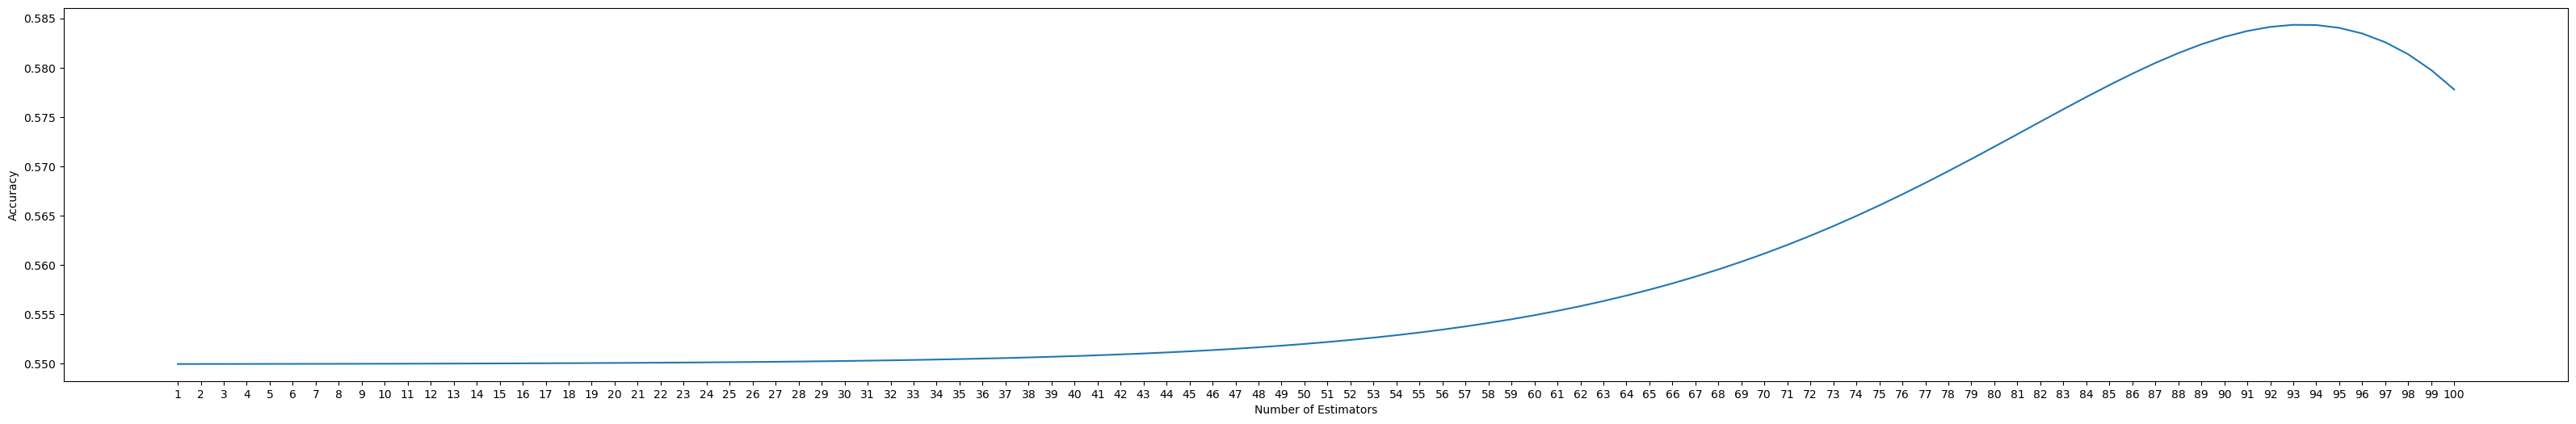

In [218]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mean_acc is your numpy array
highest_value = np.max(mean_acc)
highest_index = np.argmax(mean_acc)
print("Highest value:", highest_value)
print("Index of highest value:", highest_index)

loc = np.arange(1, 101, step=1.0)
plt.figure(figsize=(40, 6))
plt.plot(range(1, 101), mean_acc)
plt.xticks(loc)
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.show()


In [219]:
ridge_best = Ridge(alpha = 5.21400828799969)
ridge_best.fit(X_train_scaled, y_train)

Ridge(alpha=5.21400828799969)

In [220]:
# get a prediction
y_hat = ridge_best.predict(X_train_scaled)
y_ridge = ridge_best.predict(X_test_scaled)

In [221]:
print('Training set accuracy: ', r2_score(y_train, y_hat))
print('Test set accuracy: ',r2_score(y_test, y_ridge))

Training set accuracy:  0.994364052422003
Test set accuracy:  0.584341919561761


As for Lasso, we can see some improvements by increasing the alpha max

the results we got with Ridge are not satistfying enough so let's try a different aproach

In [193]:
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import GridSearchCV

# Scale the data
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid
param_grid = {
    'alpha': np.logspace(-3, 1, 100),
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'max_iter': [1000, 2000, 3000, 4000, 5000]
}

# Initialize a Ridge model
ridge = Ridge()

# Initialize the GridSearchCV
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')

# Fit the GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print(grid_search.best_params_)

{'alpha': 10.0, 'max_iter': 1000, 'solver': 'lsqr'}


In [196]:
# Use the best model to make predictions on the test dataset
best_model = grid_search.best_estimator_
yhat = best_model.predict(X_test_scaled)

# Calculate the R2 score on the test dataset
score = r2_score(y_test, yhat)
print('Test score:', score)

Test score: 0.5777690833370273


The best results achived for each one are : 
Lasso : 0.8941285295365173

Ridge : 0.584341919561761

Based on the differences between Lasso and Ridge regression and the performance results we've seen, we can make a few assumptions:

We already know that the data are not highly correlated so its mostly not a multicollinearity issue

Lasso shrinks the coefficient all the way to zero while ridge can only do it close to zero which is an important point if there are only few relevant features.

So the we can consider these options: 

Feature Relevance: Given that Lasso performs feature selection and is outperforming Ridge, it's possible that that the dataset contains irrelevant features. Lasso is able to ignore these features by setting their coefficients to zero, which could be improving its performance.

Model Complexity: Related to the previous point, if Lasso is creating a simpler model by ignoring irrelevant features, this could be leading to better generalization on the test set and higher performance.

RFE is a method that fits the model, ranks features by importance, discards the least important features, and repeats the process. let's try it to see if they are indeed irrelevant features according to this algorithm

In [180]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# create a base classifier used to evaluate a subset of attributes
model = LinearRegression()

# create the RFE model and select 3 attributes
rfe = RFE(estimator=model, n_features_to_select=3)
rfe = rfe.fit(X_train, y_train)

# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False]
[48 15 17 80 37  4 52 29 77 34  1 16 65 62 61 81 14 84 25  5 45 85 53 79
 56 22 42 83  3 59 43 57 18  1 86 19 96 71 49 33 97 64 58 78  2 40 87 21
  8 51 50 35 54 74 10 94 44 23  9  7 36  6 92 72 82 91 13 69 68 95 67 24
 90 20 38 28 98 41 66 12 63 89 55 70 73 76 46 32  1 88 31 93 47 30 60 27
 39 75 26 11]


The first array (rfe.support_) is a boolean mask that indicates which features were selected as relevant. True means the feature is relevant and False means it's not. In our case, it seems that three features have been selected as relevant.

The second array (rfe.ranking_) gives the ranking of the features. A rank of 1 means the feature is most important. The features with a rank of 1 correspond to the True values in the rfe.support_ array.

So, in conclusion, RFE has determined that three of your features are relevant for predicting the target variable. The rest of the features are considered less important, with their ranking indicating their relative importance. Thus, according to the results of RFE method, there is indeed a lot of irrelevant features that could explain why Lasso works better than Ridge 